In [1]:
# Import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import datetime
import os

In [2]:
# Set variable for file_path and data_dir
file_path = r"/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Alzheimers_Image_data/dataset"
data_dir = pathlib.Path(file_path)

In [3]:
# Split train and validation data
SEED = 1234
BATCH_SIZE = 10
IMG_SIZE = (160, 160)

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split=0.2,
                                                         subset='training',
                                                         seed=SEED,
                                                         image_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True
                                                         )

val_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED,
                                                       image_size=IMG_SIZE,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True
                                                       )


Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


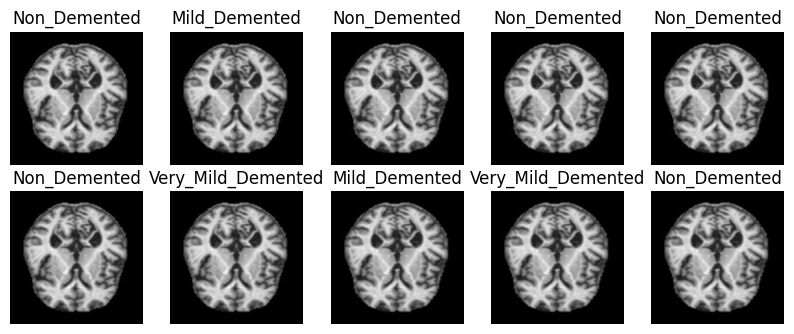

In [5]:
# set variable for class_names
class_names = train_data.class_names

# plot the train_data image
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [6]:
val_batches = tf.data.experimental.cardinality(val_data)

test_data = val_data.take(val_batches//2)

In [7]:
# Set variable for class_names
class_names = train_data.class_names

In [8]:
# Create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
#test_data = test_data.prefetch(buffer_size = AUTOTUNE)


In [9]:
# Preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.resnet50.preprocess_input
IMG_SHAPE = IMG_SIZE + (3,)


In [10]:
# Load ResNet50 model
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')


In [11]:
# Freeze the entire base_model
base_model.trainable = False

In [12]:
# Set variables for classifier and output layer
global_average_layer = GlobalAveragePooling2D()
nClass = len(class_names)
prediction_layer = Dense(nClass, activation='softmax')

In [13]:
# Reconstruct the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# Check the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [17]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [18]:
# Start training the model
initial_epochs = 1
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[tensorboard_callback, es_callback])


512/512 [==============================] - 124s 240ms/step - loss: 1.1661 - accuracy: 0.4758 - val_loss: 0.9355 - val_accuracy: 0.5586


In [19]:
# Perform fine-tuning of the trained model
# Unfreeze the top layers of the base model
base_model.trainable = True

In [20]:
# Let's take a look at the model layers
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  175


In [21]:
# So, we are going to fine-tune 10 layers ahead
fine_tune_at = 10


In [22]:
# Freeze all the layers before "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [23]:
# Compile the model again
# Use a lower learning rate for fine-tuning
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=['accuracy'])


In [24]:
# Check the model again
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [25]:
# Now, resume the model training from the last epochs
fine_tune_epochs = 7
total_epochs = initial_epochs + fine_tune_epochs

# Train the model again
history_fine_tune = model.fit(train_data,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              validation_data=val_data,
                              callbacks=[tensorboard_callback, es_callback])


Epoch 1/8


512/512 [==============================] - 366s 707ms/step - loss: 0.8965 - accuracy: 0.5717 - val_loss: 0.7903 - val_accuracy: 0.6617
Epoch 2/8
512/512 [==============================] - 379s 741ms/step - loss: 0.6488 - accuracy: 0.7246 - val_loss: 0.7475 - val_accuracy: 0.6789
Epoch 3/8
512/512 [==============================] - 384s 751ms/step - loss: 0.4094 - accuracy: 0.8328 - val_loss: 0.4155 - val_accuracy: 0.8328
Epoch 4/8
512/512 [==============================] - 390s 763ms/step - loss: 0.2131 - accuracy: 0.9219 - val_loss: 0.3495 - val_accuracy: 0.8711
Epoch 5/8
512/512 [==============================] - 406s 793ms/step - loss: 0.1234 - accuracy: 0.9592 - val_loss: 0.1854 - val_accuracy: 0.9359
Epoch 6/8
512/512 [==============================] - 401s 783ms/step - loss: 0.0863 - accuracy: 0.9723 - val_loss: 0.3569 - val_accuracy: 0.8930
Epoch 7/8
512/512 [==============================] - 392s 765ms/step - loss: 0.0660 - accuracy: 0.9805 - val_loss: 0.2303 - val_accuracy: 0.

In [26]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model-------------------------------------------")
model.evaluate(test_data)


-----------------------------------After Fine-tuning model-------------------------------------------
64/64 [==============================] - 14s 220ms/step - loss: 0.1515 - accuracy: 0.9391


[0.15153370797634125, 0.9390624761581421]

In [27]:
# Use test data to make predictions
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)


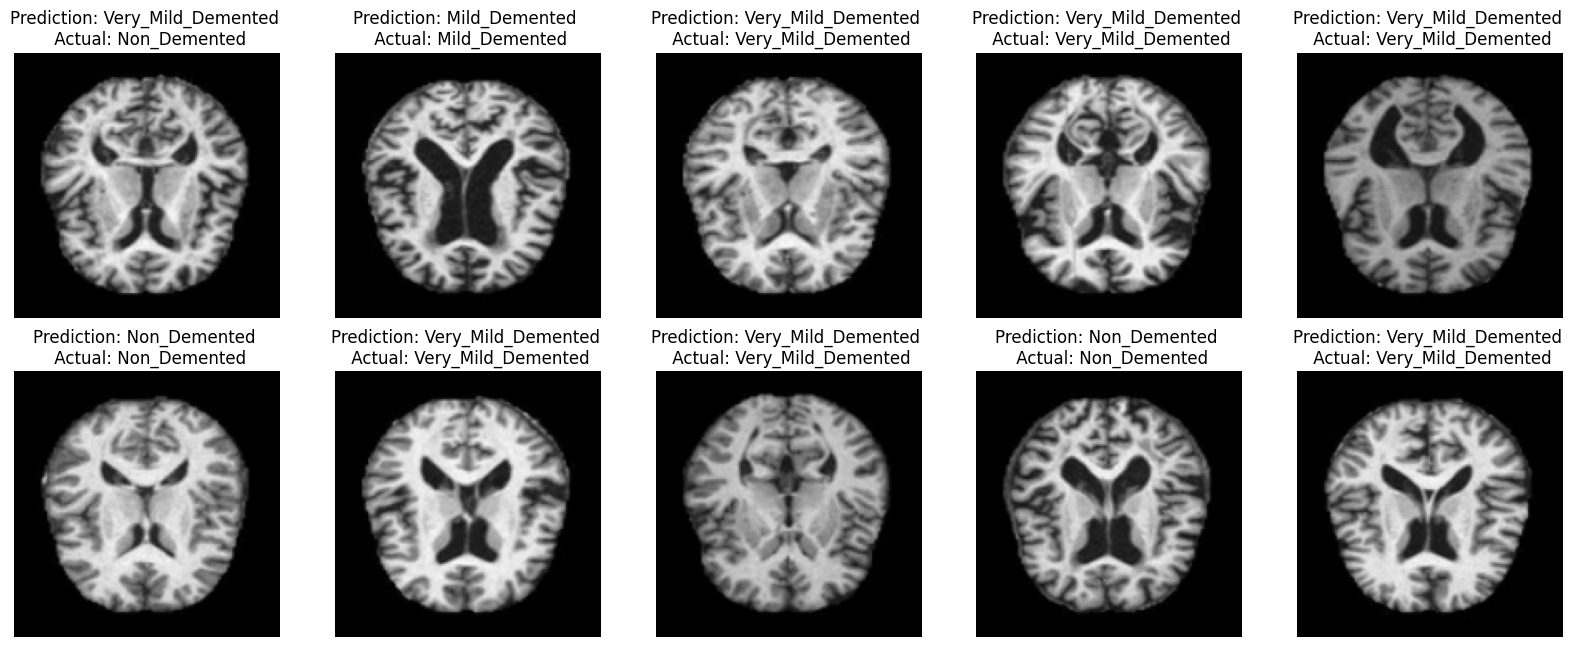

In [28]:
# Plot the prediction vs actual label
plt.figure(figsize=(20, 20))
for i in range(10):
    axs = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction} \n Actual: {current_label}")
    plt.axis('off')

# Show plots
plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Initialize empty arrays to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through all batches in the test data
for image_batch, label_batch in test_data.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    class_predictions = np.argmax(predictions, axis=1)
    
    # Append current batch predictions and labels to the arrays
    all_predictions.extend(class_predictions)
    all_labels.extend(label_batch)

# Convert the lists to numpy arrays for easy calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[ 92   0   1   0]
 [  1   6   0   0]
 [  7   0 297  14]
 [  5   0  12 205]]
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.88      0.99      0.93        93
 Moderate_Demented       1.00      0.86      0.92         7
      Non_Demented       0.96      0.93      0.95       318
Very_Mild_Demented       0.94      0.92      0.93       222

          accuracy                           0.94       640
         macro avg       0.94      0.93      0.93       640
      weighted avg       0.94      0.94      0.94       640



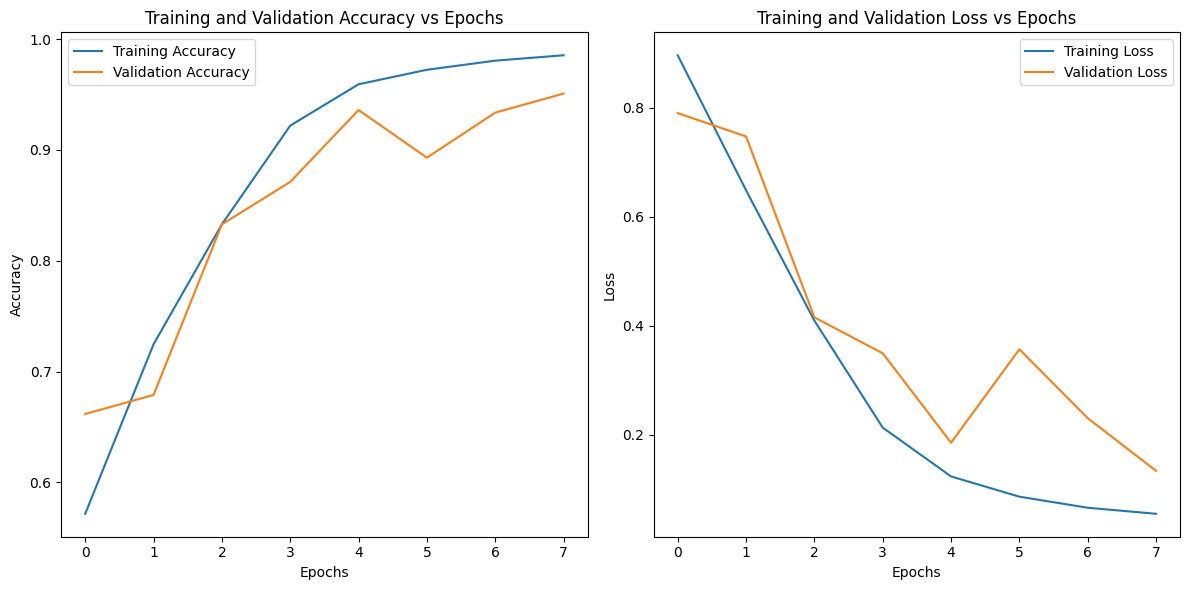

In [31]:
# Get the training history
history_dict = history_fine_tune.history

# Plot training/validation accuracy vs epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training/validation loss vs epochs
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()